In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/.DS_Store
/kaggle/input/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/per

In [2]:
# Importing essential libraries with organized grouping
import os
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Importing TensorFlow and Keras for deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Setting a consistent style for plots
sns.set(style="whitegrid")

2025-05-30 17:32:28.301841: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748626348.600646      13 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748626348.691307      13 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Labels and image size defined globally
LABELS = ['PNEUMONIA', 'NORMAL']
IMG_SIZE = 150

def get_training_data(data_dir):
    data = []  # To store image data and corresponding labels
    
    for label in LABELS:
        path = os.path.join(data_dir, label)
        class_num = LABELS.index(label)
        
        if not os.path.exists(path):
            print(f"Warning: Directory {path} does not exist.")
            continue      

        # Listing image files with proper error handling
        image_files = [f for f in os.listdir(path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        if not image_files:
            print(f"Warning: No images found in {path}.")
        
        for img_name in image_files:
            img_path = os.path.join(path, img_name)
            try:
                img_arr = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                
                if img_arr is None:
                    raise ValueError(f"Image {img_name} could not be loaded.")
                
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE))
                data.append([resized_arr, class_num])
                
            except Exception as e:
                print(f"Error processing {img_name}: {e}")
    
    # Converting to NumPy array for efficient processing
    data = np.array(data, dtype=object)
    return data

In [4]:
# Unified data loader function
def load_dataset(base_dir, dataset_type):
    print(f"Loading {dataset_type} data from: {base_dir}")
    data = get_training_data(base_dir)
    print(f"{dataset_type.capitalize()} data loaded: {len(data)} samples")
    return data

# Dataset paths
base_path = '../input/chest-xray-pneumonia/chest_xray/chest_xray'

# Loading datasets with improved handling
train_path = os.path.join(base_path, 'train')
test_path = os.path.join(base_path, 'test')
val_path = os.path.join(base_path, 'val')

# Loading the datasets
train_data = load_dataset(train_path, 'training')
test_data = load_dataset(test_path, 'testing')
val_data = load_dataset(val_path, 'validation')

Loading training data from: ../input/chest-xray-pneumonia/chest_xray/chest_xray/train
Training data loaded: 5216 samples
Loading testing data from: ../input/chest-xray-pneumonia/chest_xray/chest_xray/test
Testing data loaded: 624 samples
Loading validation data from: ../input/chest-xray-pneumonia/chest_xray/chest_xray/val
Validation data loaded: 16 samples


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


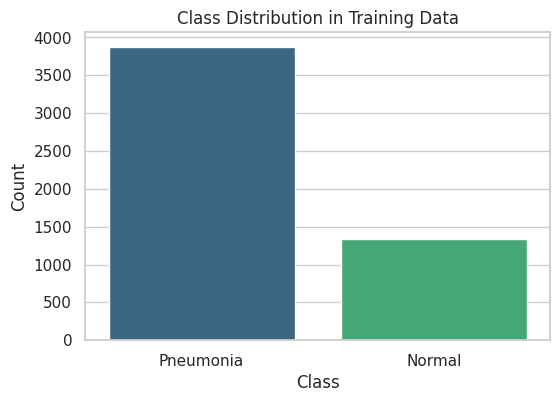

In [5]:
# Mapping labels for better readability
label_mapping = {0: "Pneumonia", 1: "Normal"}

# Data Visualization - Class Distribution
plt.figure(figsize=(6, 4))
class_labels = [label_mapping[label] for _, label in train_data]
sns.countplot(x=class_labels, palette="viridis")
plt.title("Class Distribution in Training Data")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

In [6]:
# Visualizing Sample Images
def plot_sample_image(image, label, figsize=(5, 5)):
    plt.figure(figsize=figsize)
    plt.imshow(image, cmap='gray')
    plt.title(f"Label: {label_mapping[label]}")
    plt.axis('off')
    plt.show()

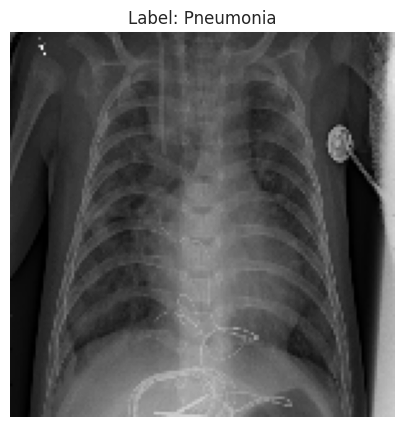

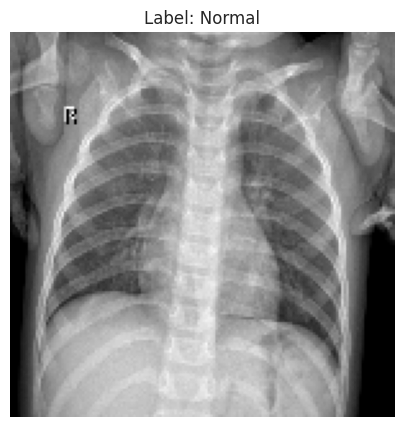

In [7]:
# Displaying the first and last images in the training set
plot_sample_image(train_data[0][0], train_data[0][1])
plot_sample_image(train_data[-1][0], train_data[-1][1])

In [8]:
# Data Preparation (Using NumPy for Efficiency)
def prepare_data(dataset):
    features, labels = zip(*dataset)
    features = np.array(features) / 255.0  # Normalizing pixel values
    features = features.reshape(-1, IMG_SIZE, IMG_SIZE, 1)  # Reshaping for CNN input
    labels = np.array(labels)
    return features, labels

In [9]:
# Preparing data for model training
x_train, y_train = prepare_data(train_data)
x_val, y_val = prepare_data(val_data)
x_test, y_test = prepare_data(test_data)

# Confirming data shapes
print(f"Training data shape: {x_train.shape}, Labels shape: {y_train.shape}")
print(f"Validation data shape: {x_val.shape}, Labels shape: {y_val.shape}")
print(f"Test data shape: {x_test.shape}, Labels shape: {y_test.shape}")

Training data shape: (5216, 150, 150, 1), Labels shape: (5216,)
Validation data shape: (16, 150, 150, 1), Labels shape: (16,)
Test data shape: (624, 150, 150, 1), Labels shape: (624,)


In [10]:
# Data Augmentation Configuration
datagen = ImageDataGenerator(
    rotation_range=30,               # Randomly rotate images (0-180 degrees)
    zoom_range=0.2,                  # Randomly zoom images
    width_shift_range=0.1,           # Randomly shift images horizontally
    height_shift_range=0.1,          # Randomly shift images vertically
    horizontal_flip=True,            # Randomly flip images horizontally
    vertical_flip=False,             # Randomly flip images vertically (disabled for medical images)
    fill_mode='nearest'              # Fill in missing pixels after transformation
)

# Fitting the Data Augmentation Model
datagen.fit(x_train)

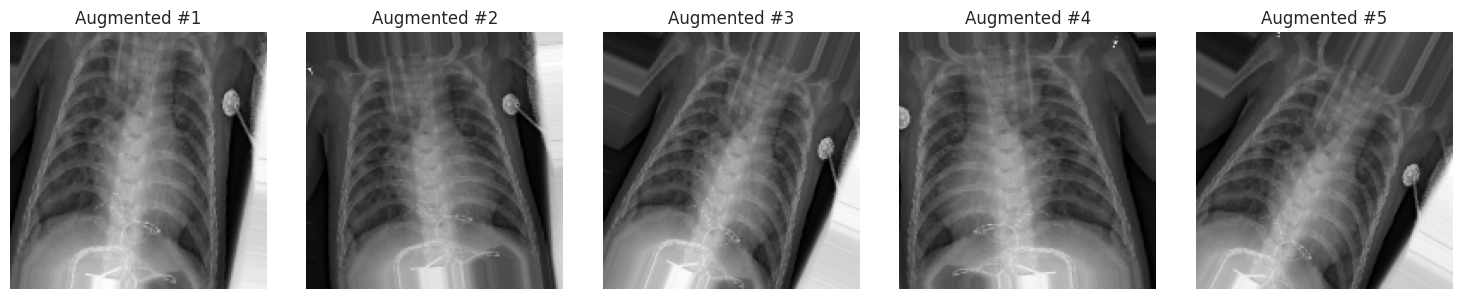

In [11]:
# Sample Visualizations to Verify Augmentation
def plot_augmented_images(datagen, x_sample, n=5):
    plt.figure(figsize=(15, 3))
    for i in range(n):
        augmented_img = datagen.random_transform(x_sample[0])  # Apply random augmentation
        plt.subplot(1, n, i + 1)
        plt.imshow(augmented_img.squeeze(), cmap='gray')
        plt.title(f"Augmented #{i+1}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Visualizing augmented samples
plot_augmented_images(datagen, x_train)

In [12]:
# Model Architecture
model = Sequential([
    Conv2D(32, (3, 3), strides=1, padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    
    Conv2D(64, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.1),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    
    Conv2D(128, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    
    Conv2D(256, (3, 3), strides=1, padding='same', activation='relu'),
    Dropout(0.2),
    BatchNormalization(),
    MaxPooling2D((2, 2), strides=2, padding='same'),
    
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.3),  # Increased dropout to prevent overfitting
    Dense(1, activation='sigmoid')  # Binary classification (Pneumonia vs Normal)
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2025-05-30 17:34:08.076985: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [13]:
# Compile the Model
model.compile(
    optimizer='adam',              # Replacing RMSprop with Adam for better convergence
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Model Summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 150, 150, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 75, 75, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 75, 75, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 75, 75, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 38, 38, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 38, 38, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 38, 38, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 38, 38, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 19, 19, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 19, 19, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 19, 19, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 19, 19, 256)         │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 10, 10, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25600)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,276,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 3,666,817 (13.99 MB)

 Trainable params: 3,665,857 (13.98 MB)

 Non-trainable params: 960 (3.75 KB)

In [14]:
#Learning Rate Reduction Callback
learning_rate_reduction = ReduceLROnPlateau(
    monitor='val_accuracy',
    patience=3,                  # Increased patience for stability
    verbose=1,
    factor=0.3,
    min_lr=0.000001
)

In [15]:
#Model Training
history = model.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    epochs=12,
    validation_data=datagen.flow(x_val, y_val),
    callbacks=[learning_rate_reduction]
)

Epoch 1/12


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 289s 2s/step - accuracy: 0.7986 - loss: 1.1728 - val_accuracy: 0.5000 - val_loss: 10.2559 - learning_rate: 0.0010
Epoch 2/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.9000 - loss: 0.2529 - val_accuracy: 0.5000 - val_loss: 4.1782 - learning_rate: 0.0010
Epoch 3/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.9189 - loss: 0.2175 - val_accuracy: 0.5000 - val_loss: 10.6653 - learning_rate: 0.0010
Epoch 4/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.9219 - loss: 0.1984
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 282s 2s/step - accuracy: 0.9219 - loss: 0.1984 - val_accuracy: 0.5000 - val_loss: 4.7347 - learning_rate: 0.0010
Epoch 5/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 281s 2s/step - accuracy: 0.9373 - loss: 0.1726 - val_accuracy: 0.5625 - val_loss: 3.1605 - learning_rate: 3.0000e-04
Epoch 6/12
163/163 ━━━━━━━━━━━━━━━━━━━━ 283s 2s/step - accuracy: 0.9476 - loss: 0.1470 - v

In [16]:
#Model Evaluation
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

20/20 ━━━━━━━━━━━━━━━━━━━━ 6s 312ms/step - accuracy: 0.8722 - loss: 0.3387
Test Loss: 0.3446
Test Accuracy: 87.98%


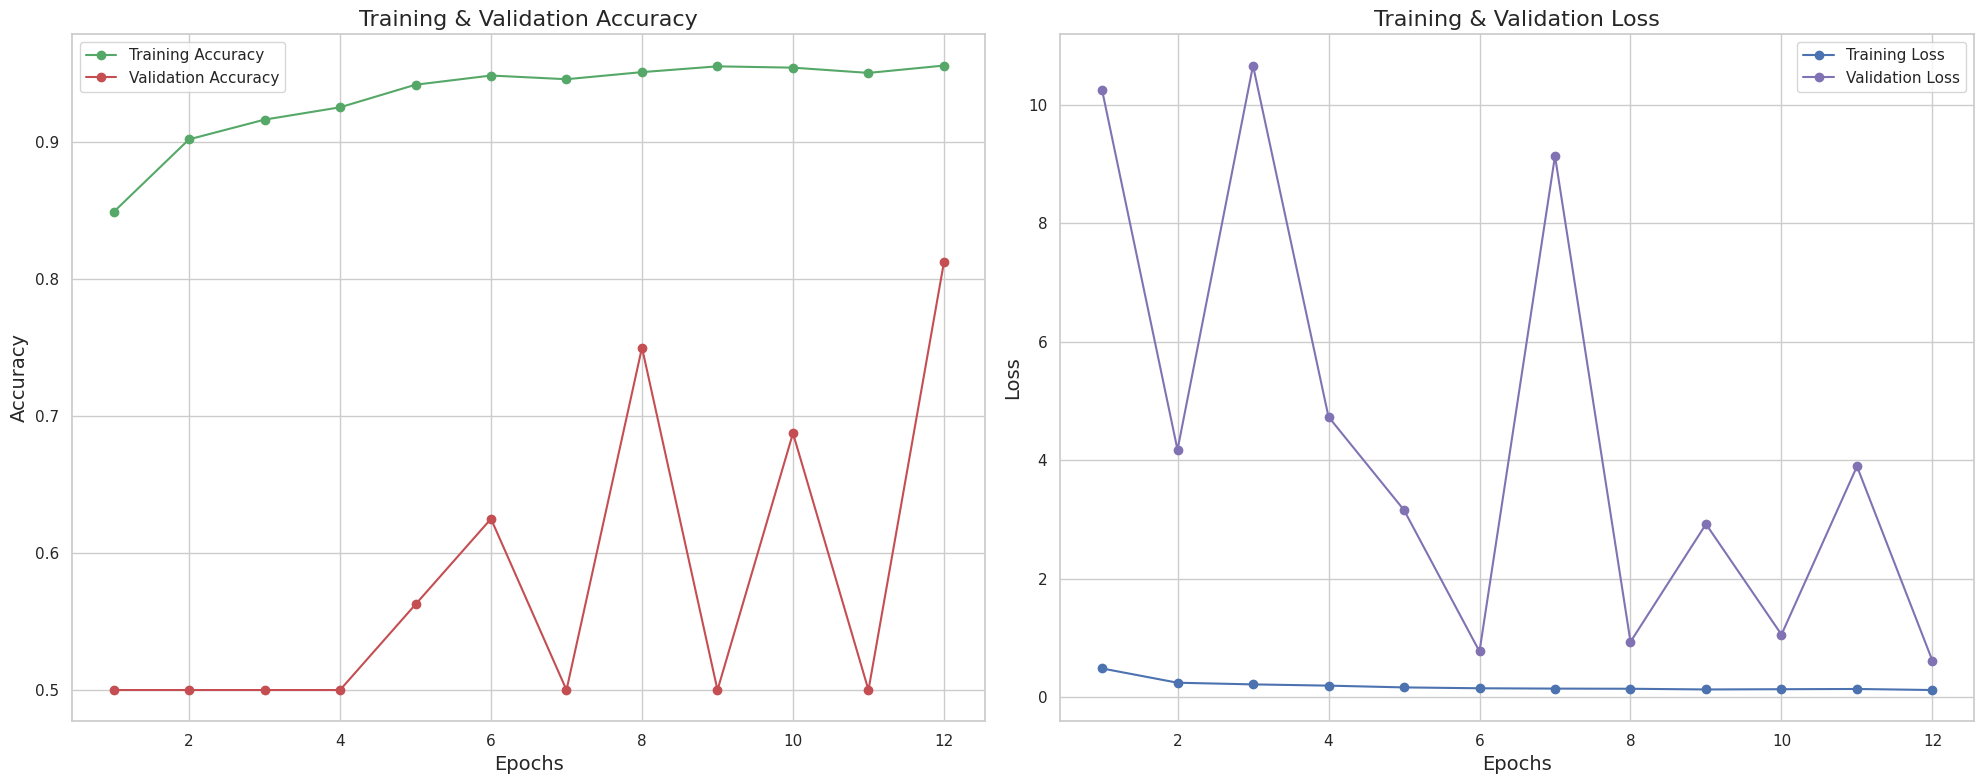

In [17]:
# Plotting Training & Validation Accuracy and Loss
epochs = range(1, 13)  # Epochs from 1 to 12

# Extracting metrics from training history
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Creating subplots for accuracy and loss
fig, ax = plt.subplots(1, 2, figsize=(20, 8))

# Accuracy Plot
ax[0].plot(epochs, train_acc, 'g-o', label='Training Accuracy')
ax[0].plot(epochs, val_acc, 'r-o', label='Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy', fontsize=16)
ax[0].set_xlabel("Epochs", fontsize=14)
ax[0].set_ylabel("Accuracy", fontsize=14)
ax[0].legend()

# Loss Plot
ax[1].plot(epochs, train_loss, 'b-o', label='Training Loss')
ax[1].plot(epochs, val_loss, 'm-o', label='Validation Loss')
ax[1].set_title('Training & Validation Loss', fontsize=16)
ax[1].set_xlabel("Epochs", fontsize=14)
ax[1].set_ylabel("Loss", fontsize=14)
ax[1].legend()

plt.tight_layout()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 7s 322ms/step
                     precision    recall  f1-score   support

Pneumonia (Class 0)       0.93      0.87      0.90       390
   Normal (Class 1)       0.81      0.89      0.85       234

           accuracy                           0.88       624
          macro avg       0.87      0.88      0.87       624
       weighted avg       0.88      0.88      0.88       624



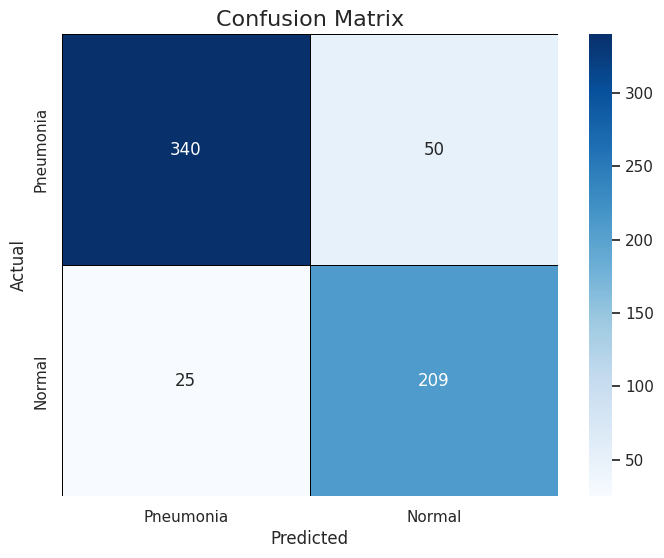

In [18]:
#Model Predictions
predictions = (model.predict(x_test) > 0.5).astype("int32").flatten()  # Updated for compatibility
print(classification_report(y_test, predictions, target_names=['Pneumonia (Class 0)', 'Normal (Class 1)']))

#Confusion Matrix Visualization
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=['Pneumonia', 'Normal'], columns=['Pneumonia', 'Normal'])

plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', linewidths=0.5, linecolor='black')
plt.title("Confusion Matrix", fontsize=16)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

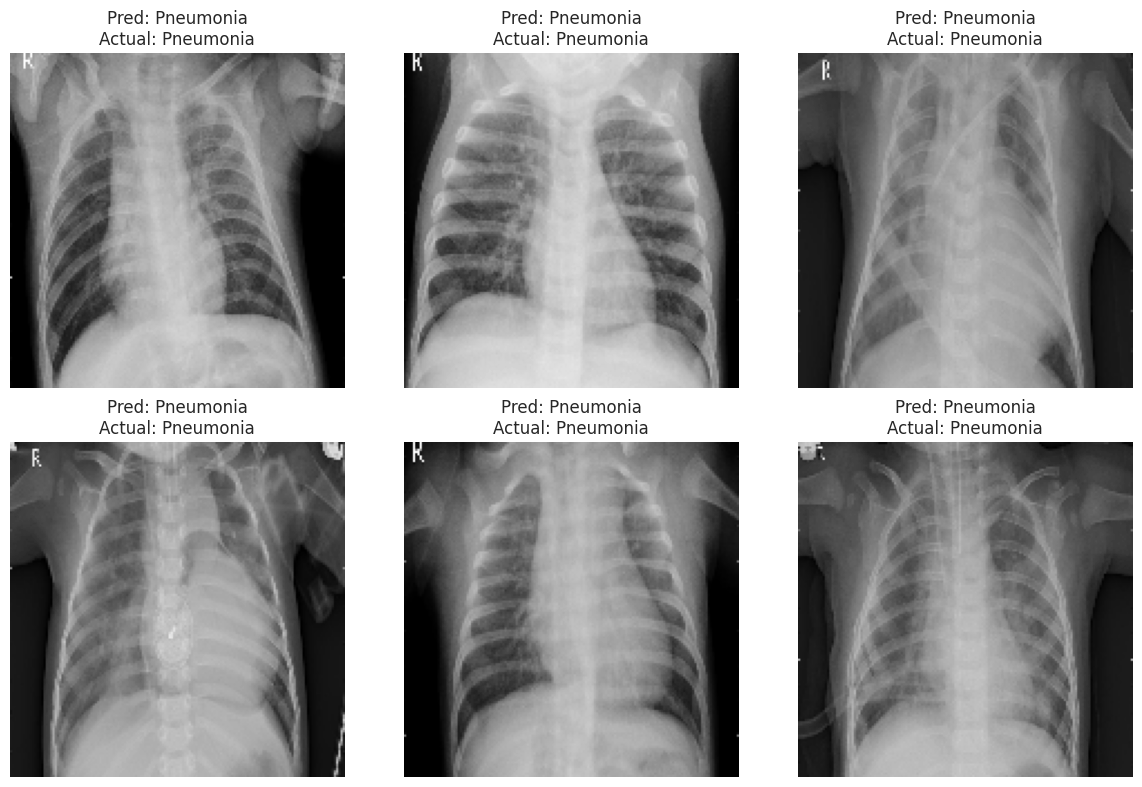

Classification Report:
               precision    recall  f1-score     support
0              0.931507  0.871795  0.900662  390.000000
1              0.806950  0.893162  0.847870  234.000000
accuracy       0.879808  0.879808  0.879808    0.879808
macro avg      0.869228  0.882479  0.874266  624.000000
weighted avg   0.884798  0.879808  0.880865  624.000000


In [19]:
# Misclassified Image Analysis
misclassified_indices = np.where(predictions == y_test)[0]

plt.figure(figsize=(12, 8))
for i, idx in enumerate(misclassified_indices[:6]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_test[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Pred: {label_mapping[predictions[idx]]}\nActual: {label_mapping[y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()
# 📊 Generating and Displaying the Classification Report
report = classification_report(y_test, predictions, output_dict=True)
report_df = pd.DataFrame(report).transpose()

print("Classification Report:\n", report_df)


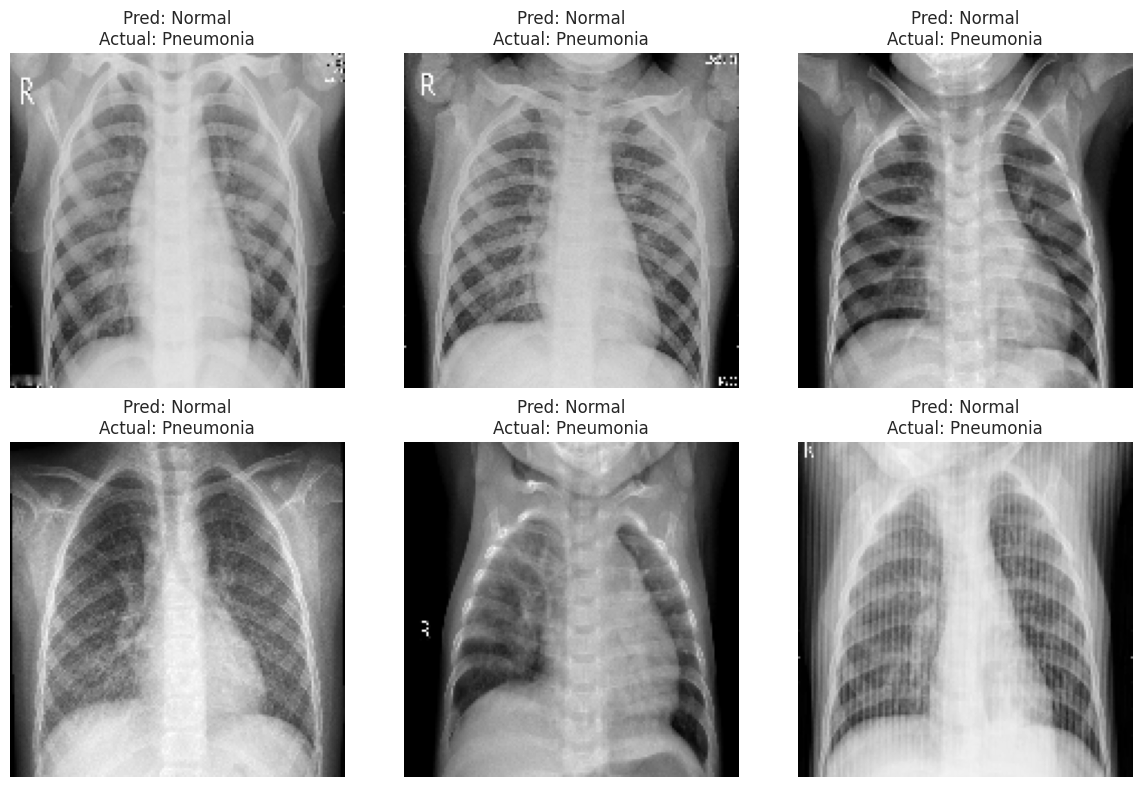

Classification Report:
               precision    recall  f1-score     support
0              0.931507  0.871795  0.900662  390.000000
1              0.806950  0.893162  0.847870  234.000000
accuracy       0.879808  0.879808  0.879808    0.879808
macro avg      0.869228  0.882479  0.874266  624.000000
weighted avg   0.884798  0.879808  0.880865  624.000000


In [20]:
#Misclassified Image Analysis
misclassified_indices = np.where(predictions != y_test)[0]

plt.figure(figsize=(12, 8))
for i, idx in enumerate(misclassified_indices[:6]):
    plt.subplot(2, 3, i + 1)
    plt.imshow(x_test[idx].reshape(IMG_SIZE, IMG_SIZE), cmap='gray')
    plt.title(f"Pred: {label_mapping[predictions[idx]]}\nActual: {label_mapping[y_test[idx]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

# Displaying the Classification Report
print("Classification Report:\n", report_df)

In [21]:
# Saving the trained model
model.save("model5.h5")
print(" Model saved as model5.h5")

 Model saved as model5.h5
